In [2]:
import pandas as pd
import numpy as np
import time
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from collections import Counter
import pickle
import ast
import networkx as nx
from networkx.algorithms import bipartite
import random

In [3]:
def save_obj(obj, name ):
    with open('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
train = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train.csv')
test_cluster_batch = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/test_cluster_batch.csv')
train_clustered = pd.read_csv('/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/train_clustered.csv')

users_dict = load_obj('users_dict')
tracks_dict = load_obj('tracks_dict')
clusters_dict = load_obj('clusters_dict')

In [6]:
test_mini = test_cluster_batch[test_cluster_batch['CF']!=-99] #877

In [208]:
test_mini.head(1)

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,...,artist_tag,predict,CF,dummy,like,CF_raw,SONG_AVG,SONG_Q,track_label,user_label
0,82ef16cb5e45c1afe71979afcc6dbae8fdd36aeb,8,TRBDQUF128F42AE54C,SOBBFWL12A8C140087,Daler Mehndi;Chitra,Rang De Basanti,363.80689,-7.403,105.026,0.363686,...,[b'singer' b'dancer' b'indian'],49,2.0,0,2,9.616318,8.628472,5.0,2920,63564


In [207]:
len(test_mini[test_mini.like == test_mini.CF])/len(test_mini)

0.3055872291904219

In [212]:
len(test_mini[(test_mini.CF == test_mini.like) & (test_mini.CF==2)])/len(test_mini)

0.13112884834663627

In [75]:
len(test_mini.track_id.unique()) #344

344

In [76]:
len(test_mini.user.unique()) # 873

873

In [7]:
test_user_history = set(train[train.user.isin(test_mini.user)]['track_id']) # 1910 history records

In [217]:
len(test_user_history)

564

In [8]:
all_songs = test_user_history|set(test_mini.track_id.values)

In [214]:
len(all_songs)

691

In [9]:
# users that have listened to test data songs
train['_flag'] = train.apply(lambda x: 1 if x['track_id'] in set(test_mini['track_id']) else 0,axis=1)
train['_flag'] = train.groupby(["user"])["_flag"].transform('sum')
filtered_train = train[train['_flag']>=1]

# users that have listened to test_user_history
train['_flag2'] = train.apply(lambda x: 1 if x['track_id'] in  test_user_history else 0,axis=1)
train['_flag2'] = train.groupby(["user"])["_flag2"].transform('sum')
filtered_train2 = train[train['_flag2']>=1] 

In [10]:
valuable_user = set(filtered_train2.user.values)&set(filtered_train.user.values) # listened to both

In [181]:
len(valuable_user)

105986

In [12]:
all_users = set(valuable_user)

In [13]:
train_mini = train[(train.track_id.isin(all_songs)) & (train.user.isin(all_users))] # 286,480

In [14]:
train_mini.shape

(286480, 22)

In [15]:
history = list(zip(train_mini.user.values,train_mini.track_id.values))
len(history)

286480

In [16]:
# Bipariate
B = nx.Graph()
B.add_nodes_from(train_mini.user.values, bipartite=0) # user
B.add_nodes_from(train_mini.track_id.values, bipartite=1) # song
# Add edges only between nodes of opposite node sets
B.add_edges_from(history)

In [172]:
len(B.edges)

6296

In [188]:
nx.is_connected(B)

True

In [17]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [190]:
len(bottom_nodes)

105986

In [18]:
len(top_nodes) # missing 1 song: nobody has listened to this plus some other songs in history

690

In [19]:
# one mode projection
projection = bipartite.weighted_projected_graph(B, top_nodes)

/anaconda3/envs/si618/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


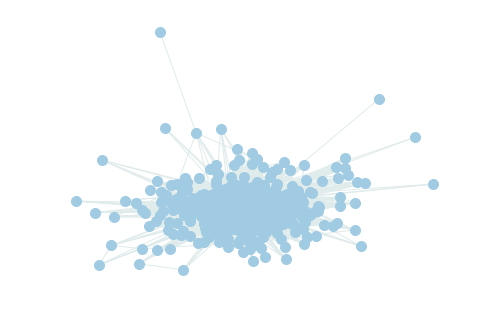

In [99]:
pos = nx.spring_layout(projection)

nx.draw(projection, pos,node_color='#A0CBE2',node_size=100,
        width=1, edge_color = "#e0ebeb", with_labels=False)
plt.show()

/anaconda3/envs/si618/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


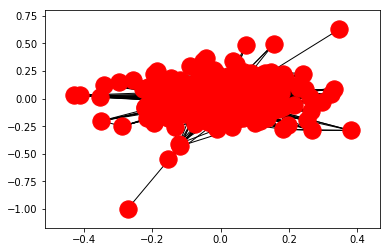

In [195]:
nx.draw_networkx(projection, with_labels=False)
plt.show()

In [193]:
len(projection.nodes)

690

In [128]:
len(bottom_nodes)

156

In [194]:
projection.degree()

DegreeView({'TRANMKF128E07995A8': 239, 'TRATBNG128F92CADA8': 377, 'TRAPNQZ128F145B04E': 27, 'TRADXCO128F426B26D': 14, 'TRANWCP12903CF31D3': 18, 'TRAGETA128F4272C38': 36, 'TRAJNZF12903CB22A9': 194, 'TRAKHXX128E07877EB': 218, 'TRAPMTY128F1459DA1': 75, 'TRALKBS128F423BB4C': 101, 'TRACCJA128F149A144': 118, 'TRAJCOV128F92FDF3F': 3, 'TRBDIOP128EF35F99C': 280, 'TRAIGZU128F4236EB6': 190, 'TRBEQFT128F146BD6D': 249, 'TRAYQLP128F92FA224': 538, 'TRBDNDG128E0782EDC': 363, 'TRBCIDX128F422F215': 243, 'TRAUEYX12903CEAF48': 150, 'TRAXLPR128F428E466': 312, 'TRARJEM128F92E444D': 203, 'TRAXLIU128E07860D4': 195, 'TRAVYNN128F425EBBC': 188, 'TRBAMES128F14947D4': 21, 'TRAPVXU128F149E7CD': 312, 'TRAVYRR128F423C597': 98, 'TRAVXEP128F14539AE': 162, 'TRBEKNV128F9326A8A': 163, 'TRBHYTA128F93425AC': 195, 'TRAOOGD128F92E4768': 321, 'TRACTIE128F92E473B': 290, 'TRAWYNV128F92F5E7E': 306, 'TRAWEIX128F14B0F05': 313, 'TRAQEVV128EF34E413': 204, 'TRBFQII128F930D519': 21, 'TRBACGF128F92C5774': 218, 'TRAGNGY12903C9CD76': 84, 

In [229]:
neighbors = projection["TRANMKF128E07995A8"].values()
weights = []
for n in neighbors:
    
    weights.append(n['weight']) 
    
weights

[1,
 16,
 2,
 2,
 1,
 4,
 2,
 1,
 1,
 160,
 18,
 1,
 1,
 11,
 2,
 3,
 2,
 34,
 2,
 1,
 1,
 1,
 1,
 2,
 3,
 8,
 2,
 1,
 3,
 2,
 2,
 2,
 5,
 1,
 4,
 2,
 2,
 2,
 4,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 17,
 1,
 1,
 2,
 6,
 6,
 1,
 1,
 2,
 1,
 4,
 2,
 1,
 3,
 9,
 15,
 1,
 1,
 5,
 1,
 12,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 4,
 1,
 2,
 2,
 1,
 1,
 3,
 3,
 1,
 1,
 5,
 7,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 5,
 1,
 2,
 1,
 1,
 5,
 3,
 1,
 2,
 2,
 10,
 1,
 2,
 4,
 2,
 1,
 3,
 151,
 1,
 1,
 2,
 1,
 1,
 2,
 6,
 2,
 1,
 3,
 1,
 1,
 4,
 1,
 12,
 2,
 13,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 4,
 7,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 4,
 5,
 3,
 1,
 1,
 3,
 6,
 2,
 1,
 1,
 2,
 5,
 1,
 1,
 2,
 6,
 5,
 2,
 1,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 1,
 4,
 1,
 5,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 16,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 5,
 1,
 3,
 1,
 27,
 20]

In [216]:
for i in projection["TRANMKF128E07995A8"]:
    print(i)

TRAGEVS128F145FEAD
TRAADLN128F14832E9
TRBALRR128F429625D
TRAADVH128EF34DE7A
TRBGKGR128F92EE206
TRAXLZU12903D05F94
TRATBNG128F92CADA8
TRAYABW128F4235888
TRALOBE12903CDA6C5
TRBDMIN128F147FCBB
TRANBUW128F933C645
TRAWRKT128E0788857
TRAJNZF12903CB22A9
TRAWBHE12903CBC4CB
TRAKLHO128F42BA554
TRAAMES128F42AF068
TRAUTTP128F425BDEB
TRAEVRI128F93608F3
TRAUURC128E078EC6E
TRASTIS128F92FA998
TRANHYE128F92DE232
TRBBQGV12903CB5CD3
TRBDIOP128EF35F99C
TRAAEEH128E0795DFE
TRBDNDG128E0782EDC
TRAYQLP128F92FA224
TRBAUHT128F92F0657
TRAXLPR128F428E466
TRAPVXU128F149E7CD
TRAWMBE128F423A76C
TRBGGBF128F425E4D1
TRAIELD128F92DC682
TRBIBLJ12903CCF436
TRBHYTA128F93425AC
TRAAGCZ128F93210FD
TRBDRIN128F9308ABF
TRAOOGD128F92E4768
TRASSZI128F146EC5F
TRARTEH128F423DBC1
TRBICGT128E0792473
TRAWEIX128F14B0F05
TRAZSCZ128F42554F4
TRBCTBG128F42B7E1B
TRACFXL128F930B28B
TRBACGF128F92C5774
TRAMKUA128F92ED3E1
TRABRMZ128F4261DED
TRAQHNX128E07822A7
TRBDYFY128F93330AA
TRAGNBQ128F149CB93
TRAZDPO128E078ECE6
TRAFHRS128F14599C0
TRAEQPB128F1

In [200]:
projection["TRANMKF128E07995A8"]['TRAADLN128F14832E9']['weight']

16

In [213]:
nx.write_gpickle(projection, "/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/projection.gpickle")

In [ ]:
#projection=nx.read_gpickle("/Users/Mengying/Desktop/Networks/Project/MSD/Data_userprofile/projection.gpickle")

In [215]:
for a in all_songs:
    if a not in top_nodes:
        print(a)

TRAJUPC128F427F008


In [103]:
nx.average_clustering(projection)

0.7036975520767043

## Random Walk, Hitting Time

In [21]:
def random_walk(starting_nodes, g=projection, alpha = 0.4, k=5, discount=0.25):
    # perform alpha terminating random walk
    global multi_walk
    
    for i in range(k):
        for h in starting_nodes:
            if h == 'TRAJUPC128F427F008': # not in graph
                continue
            path = []
            #start = np.random.choice(starting_nodes, 1)[0]
            start = h
            path.append(start)
            neighbors = projection[start].values()
            weights = [n['weight'] for n in neighbors]

            if len(g[start]) == 1:
                continue
            next_node = np.random.choice(g[start], 1, p=weights/np.sum(weights))[0]
            
            step = 1
            path.append(next_node)
            while next_node is not None:

                r = random.random()
                if r < alpha:
                    end = next_node
                    next_node = None
                    #hits[(h,end)] = discount**step+hits.get((h,end), 0)
                    
                else:
                    start = next_node # jump to next node and start again
                    
                    neighbors = projection[start].values()
                    weights = [n['weight'] for n in neighbors]

                    if len(g[start]) == 1:
                        break    
                    next_node = np.random.choice(g[start], 1, p=weights/np.sum(weights))[0]
                    
                    step +=1
                    path.append(next_node)
            
            # multi-walk
            for p in range(len(path)-1):
                stepsize = 1
                for k in range(p+1, len(path)):
                    if path[p] in test_user_history:
                        multi_walk[(path[p],path[k])] = discount**stepsize+multi_walk.get((path[p],path[k]), 0) 
                    stepsize += 1
      
    return multi_walk
            

In [83]:
# Parameter Search

discount_param = [0.01,0.05,0.10,0.20,0.30]
for d in discount_param:
    multi_walk = {}

    for user in test_mini.user.values:
        starting_nodes = train[train.user == user]['track_id'].values
        random_walk(starting_nodes,discount=d)
    
    print("param search done when d = ", d)
    print(len(multi_walk))
    save_obj(multi_walk, 'multi_walk'+str(d))
    

param search done when d =  0.01
31287
param search done when d =  0.05
31827
param search done when d =  0.1
31874
param search done when d =  0.2
31617
param search done when d =  0.3
32034


In [85]:
multi_walk_001 = load_obj('multi_walk0.01')
multi_walk_005 = load_obj('multi_walk0.05')
multi_walk_01 = load_obj('multi_walk0.1')
multi_walk_02 = load_obj('multi_walk0.2')
multi_walk_03 = load_obj('multi_walk0.3')

In [90]:
# Accuracy:
def cal_accuracy(topk,multi_walk):
    count = 0
    correct = 0
    for user in test_mini.user.values:
        true_vals = test_mini[test_mini.user == user]['track_id'].values
        starting_nodes = train[train.user == user]['track_id'].values

        user_walks = {}
        for h in starting_nodes:         
            walks = {k:v for k,v in multi_walk.items() if k[0] == h }
            user_walks.update(walks)

        user_walks = sorted(user_walks.items(), key=lambda kv: kv[1])[-topk:]
        origin, dest = zip(*list(dict(user_walks).keys()))
        for true_val in true_vals:
            if true_val in dest:
                correct += 1
                break

        count += 1


    print('accuracy: ', correct/count)
    
    return correct/count

In [91]:
topk_param = [10,25,50,75,100]
accuracy001 = []
accuracy005 = []
accuracy01 = []
accuracy02 = []
accuracy03 = []

for topk in topk_param:
    print("Top: ",topk)
    accuracy001.append(cal_accuracy(topk,multi_walk_001))
    accuracy005.append(cal_accuracy(topk,multi_walk_005))
    accuracy01.append(cal_accuracy(topk,multi_walk_01))
    accuracy02.append(cal_accuracy(topk,multi_walk_02))
    accuracy03.append(cal_accuracy(topk,multi_walk_03))

Top:  10
accuracy:  0.30216647662485746
accuracy:  0.2896237172177879
accuracy:  0.30786773090079816
accuracy:  0.3124287343215507
accuracy:  0.2998859749144812
Top:  25
accuracy:  0.4298745724059293
accuracy:  0.4298745724059293
accuracy:  0.4378563283922463
accuracy:  0.4241733181299886
accuracy:  0.427594070695553
Top:  50
accuracy:  0.5153933865450399
accuracy:  0.5153933865450399
accuracy:  0.5245153933865451
accuracy:  0.5199543899657925
accuracy:  0.5131128848346637
Top:  75
accuracy:  0.5450399087799316
accuracy:  0.5655644241733181
accuracy:  0.5769669327251995
accuracy:  0.5701254275940707
accuracy:  0.5598631698973774
Top:  100
accuracy:  0.5849486887115165
accuracy:  0.5940706955530216
accuracy:  0.5986316989737742
accuracy:  0.6031927023945268
accuracy:  0.5849486887115165


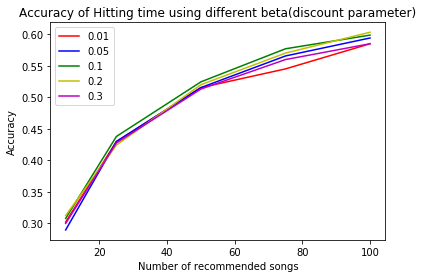

In [101]:
neighbor_number_list = [10,25,50,75,100]
plt.plot(neighbor_number_list, accuracy001, 'r',neighbor_number_list , accuracy005, 'b', neighbor_number_list, accuracy01, 'g', neighbor_number_list, accuracy02, 'y', neighbor_number_list, accuracy03, 'm')
plt.legend([0.01,0.05,0.1,0.2,0.3])
plt.xlabel('Number of recommended songs')
plt.ylabel('Accuracy')
plt.title("Accuracy of Hitting time using different beta(discount parameter)")
plt.show()

In [328]:
nx.shortest_path(projection, source='TRAGLZM128F931C995', target='TRALSXX128F92F94B0')

['TRAGLZM128F931C995', 'TRALSXX128F92F94B0']

In [329]:
projection["TRAGLZM128F931C995"]["TRALSXX128F92F94B0"]['weight']

1

In [326]:
test_mini.head(2)

,user,count,track_id,song_id,artist,song_y,duration,loudness,tempo,song_hotness,...,artist_tag,predict,CF,dummy,like,CF_raw,SONG_AVG,SONG_Q,track_label,user_label
0,82ef16cb5e45c1afe71979afcc6dbae8fdd36aeb,8,TRBDQUF128F42AE54C,SOBBFWL12A8C140087,Daler Mehndi;Chitra,Rang De Basanti,363.80689,-7.403,105.026,0.363686,...,[b'singer' b'dancer' b'indian'],49,2.0,0,2,9.616318,8.628472,5.0,2920,63564
2,a3d5597a793f2fad64f6468729711c36bb49c594,9,TRALSXX128F92F94B0,SOBSEGK12A58A7BEBF,Sex Pistols,Seventeen,129.93261,-6.458,129.722,0.704853,...,[b'british' b'punk rock' b'uk' b'london' b'eng...,62,1.0,0,2,3.353521,3.427536,1.0,1179,79550


In [365]:
train[train.user == 'a3d5597a793f2fad64f6468729711c36bb49c594']['track_id'].values

array(['TRAGLZM128F931C995'], dtype=object)